# Text Classification Tutorial
based on https://www.opencodez.com/python/text-classification-using-keras.htm

- You can choose between two Data Sets
    - Dataset ( http://archive.ics.uci.edu/ml/datasets/Reuter_50_50 ): contains documents of 50 different authors
    - Dataset ( https://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups ): contains document of 20 different newsgroup genres

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import itertools

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import metrics
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from sklearn.metrics import confusion_matrix
#from sklearn.feature_extraction.text import TfidfVectorizer
from pathlib import Path

C:\Users\Johanna\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Retrieve Data

In [2]:
# For reproducibility
np.random.seed(1237)
 
############ Newsgroup corpus ##############
#path_train = "./resources/20news-bydate/20news-bydate-train"
#path_test = "./resources/20news-bydate/20news-bydate-test"
#num_labels = 20
#test_files = [path_test + "/sci.med/59225",
#             path_test + "/sci.med/59229",
#             path_test + "/rec.autos/103007",
#             path_test + "/comp.graphics/38758",
#             path_test + "/comp.graphics/38777",]

############ Reuter corpus ############## 
path_train = "./resources/C50/C50train"
path_test = "./resources/C50/C50test"
num_labels = 50

test_files = [path_test + "/LydiaZajc/45801newsML.txt",
             path_test + "/LydiaZajc/377881newsML.txt",
            path_test + "/LydiaZajc/416661newsML.txt",
            path_test + "/FumikoFujisaki/416452newsML.txt",
            path_test + "/KouroshKarimkhany/357767newsML.txt"]


##########################

In [3]:
files_train = skds.load_files(path_train,load_content=False)

file_paths = files_train.filenames #array with paths to every file
label_names = files_train.target_names #all labels
labelled_files_index = files_train.target #array with numerical represention of label for each file

In [4]:
data_tags = ["filename","category","article"]
data_list = []

# Read and add data from file to a list
i=0
for f in file_paths:
    data_list.append((f,
                      label_names[labelled_files_index[i]],
                      Path(f).read_text()))
    i += 1
    

data = pd.DataFrame.from_records(data_list, columns=data_tags)

In [5]:
data.head()

,filename,category,article
0,./resources/C50/C50train\AlanCrosby\104278news...,AlanCrosby,The Czech Republic and Spain played to a score...
1,./resources/C50/C50train\TimFarrand\234885news...,TimFarrand,"British brewer-to-leisure group Bass Plc, said..."
2,./resources/C50/C50train\TheresePoletti\136917...,TheresePoletti,Unisys Corp. posted improved results in the th...
3,./resources/C50/C50train\JaneMacartney\247009n...,JaneMacartney,Intense haggling among the world's trade minis...
4,./resources/C50/C50train\JoeOrtiz\100554newsML...,JoeOrtiz,Channel tunnel operator Eurotunnel on Monday a...


## Prepare Data

- we split the training data into 80/20
- each element contains content, tag(category) and file name


In [6]:
#take 80% of data for training, the remaining 20% vor test/evaluation
train_size = int(len(data) * .8)
 
train_posts = data['article'][:train_size]
train_tags = data['category'][:train_size]
train_files_names = data['filename'][:train_size]
 
test_posts = data['article'][train_size:]
test_tags = data['category'][train_size:]
test_files_names = data['filename'][train_size:]

### Vectorization
- documents are modelled into tfidf vectors

In [7]:
vocab_size = 15000 #vocabulary is restricted to 15000 words

tokenizer = Tokenizer(num_words=vocab_size)#takes the most [vocab_size] frequent words
tokenizer.fit_on_texts(train_posts)#selects features

x_train = tokenizer.texts_to_matrix(train_posts, mode='tfidf') #weights features
x_test = tokenizer.texts_to_matrix(test_posts, mode='tfidf')

### One Hot Encoding
- each label will be transformed in a binary vector

In [8]:
encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

#Testprint for label vector
print("Label: '" + train_tags[0] + "' will be transformed into:")
for i in range(num_labels):
    print(encoder.classes_[i] + ": " + str(y_train[0][i]))

Label: 'AlanCrosby' will be transformed into:
AaronPressman: 0
AlanCrosby: 1
AlexanderSmith: 0
BenjaminKangLim: 0
BernardHickey: 0
BradDorfman: 0
DarrenSchuettler: 0
DavidLawder: 0
EdnaFernandes: 0
EricAuchard: 0
FumikoFujisaki: 0
GrahamEarnshaw: 0
HeatherScoffield: 0
JanLopatka: 0
JaneMacartney: 0
JimGilchrist: 0
JoWinterbottom: 0
JoeOrtiz: 0
JohnMastrini: 0
JonathanBirt: 0
KarlPenhaul: 0
KeithWeir: 0
KevinDrawbaugh: 0
KevinMorrison: 0
KirstinRidley: 0
KouroshKarimkhany: 0
LydiaZajc: 0
LynneO'Donnell: 0
LynnleyBrowning: 0
MarcelMichelson: 0
MarkBendeich: 0
MartinWolk: 0
MatthewBunce: 0
MichaelConnor: 0
MureDickie: 0
NickLouth: 0
PatriciaCommins: 0
PeterHumphrey: 0
PierreTran: 0
RobinSidel: 0
RogerFillion: 0
SamuelPerry: 0
SarahDavison: 0
ScottHillis: 0
SimonCowell: 0
TanEeLyn: 0
TheresePoletti: 0
TimFarrand: 0
ToddNissen: 0
WilliamKazer: 0


## Model Data

fitting/training of the model with training(X) & test(Y) data

In [9]:
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(512)) 
model.add(Activation('sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               7680512   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                25650     
__________

In [10]:
batch_size = 100
epochs = 5
verbose = 1 #verbosity mode
validation_split = 0.1

model.compile(loss='categorical_crossentropy', #loss function for multiclass classification
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_split=validation_split)

Train on 1800 samples, validate on 200 samples
Epoch 1/5
1800/1800 [==============================] - 7s 4ms/step - loss: 3.6876 - acc: 0.1356 - val_loss: 2.9916 - val_acc: 0.6250
Epoch 2/5
1800/1800 [==============================] - 5s 3ms/step - loss: 2.3013 - acc: 0.7161 - val_loss: 1.9401 - val_acc: 0.7850
Epoch 3/5
1800/1800 [==============================] - 6s 3ms/step - loss: 1.1569 - acc: 0.9344 - val_loss: 1.1684 - val_acc: 0.8550
Epoch 4/5
1800/1800 [==============================] - 5s 3ms/step - loss: 0.4931 - acc: 0.9789 - val_loss: 0.7988 - val_acc: 0.8900
Epoch 5/5
1800/1800 [==============================] - 5s 3ms/step - loss: 0.2209 - acc: 0.9950 - val_loss: 0.6621 - val_acc: 0.8950


### Evaluation

In [11]:
result = model.evaluate(x_test, y_test,
                    batch_size=batch_size,
                    verbose=1)

print(model.metrics_names)
print(result)

500/500 [==============================] - 0s 812us/step
['loss', 'acc']
[0.6883858680725098, 0.8319999933242798]


## Predicting some unseen documents

- files are taken from the test folder
- steps: content tokenization, prediction, comparison with actual tag

In [12]:
x_data = []
for t_f in test_files:
    t_f_data = Path(t_f).read_text()
    x_data.append(t_f_data)
 
x_data_series = pd.Series(x_data)
x_vectorized = tokenizer.texts_to_matrix(x_data_series, mode='tfidf')

In [13]:
i=0
for x_t in x_vectorized:
    print(x_data[i][:80])
    prediction = model.predict(np.array([x_t])) #returns propabilities for each label
    predicted_label = encoder.classes_[np.argmax(prediction[0])] #chooses the most propable label
    print("File ->", test_files[i], "Predicted label: " + predicted_label)
    print("********************************")
    i += 1

The Toronto Stock Exchange's move to decimal trading from fractions this year ha
File -> ./resources/C50/C50test/LydiaZajc/45801newsML.txt Predicted label: LydiaZajc
********************************
The Toronto stock market ended mixed in heavy dealings on Friday but the key ind
File -> ./resources/C50/C50test/LydiaZajc/377881newsML.txt Predicted label: LydiaZajc
********************************
Software maker Cognos Inc sees another strong year in fiscal 1998 and a share bu
File -> ./resources/C50/C50test/LydiaZajc/416661newsML.txt Predicted label: KevinDrawbaugh
********************************
Japanese workers are facing another year of marginal salary increases as traditi
File -> ./resources/C50/C50test/FumikoFujisaki/416452newsML.txt Predicted label: FumikoFujisaki
********************************
Apple Computer Inc. said Tuesday it will consolidate its independent marketing a
File -> ./resources/C50/C50test/KouroshKarimkhany/357767newsML.txt Predicted label: KouroshKarimkhany
***

## Evaluate on Test Data
### Retrieve Data

In [14]:
files_test = skds.load_files(path_test,load_content=False)

In [15]:
file_paths = files_test.filenames #array with paths to every file
label_names = files_test.target_names #all labels
labelled_files_index = files_test.target #array with numerical represention of label for each file

In [16]:
data_tags = ["filename","category","article"]
data_list = []

# Read and add data from file to a list
i=0
for f in file_paths:
    data_list.append((f,
                      label_names[labelled_files_index[i]],
                      Path(f).read_text()))
    i += 1
    

data = pd.DataFrame.from_records(data_list, columns=data_tags)

### Prepare Data

In [17]:
test_posts = data['article']
test_tags = data['category']
test_files_names = data['filename']

In [18]:
#x_test = vectorizer.transform(test_posts)
x_test = tokenizer.texts_to_matrix(test_posts, mode='tfidf')

encoder = LabelBinarizer()
encoder.fit(train_tags)
y_test = encoder.transform(test_tags)

### Predict Labels

In [19]:
probs = model.predict(x_test) #matrix with probabilities for each label per document
y_pred = np.argmax(probs, axis=1)#array with labels for each document

### Visualize Results

In [20]:
cf = confusion_matrix(y_pred, labelled_files_index)

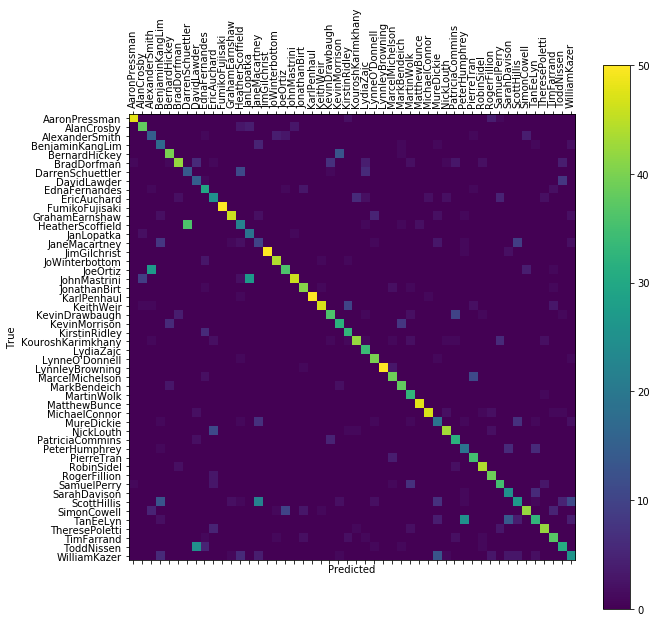

In [21]:
labels = encoder.classes_

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(cf)
fig.colorbar(cax)
ax.set_yticks(np.arange(len(labels)))
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_yticklabels(labels)
#ax.set_yticklabels(np.arrage(len(test_tags)), test_tags)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()